In [1]:
# System libraries
import time
import io
import itertools

import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

# Custom libraries
import load_mnist as mnist

%matplotlib inline

### Load dataset

In [2]:
training_data, _, testing_data = mnist.read_mnist('data/mnist/', flatten=True)

### Custom Dataset Loader

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.images = data[0]
        self.labels = data[1]
        self.transform = transform
        self.len = len(self.labels)

    def __getitem__(self, idx):

        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image, label = self.transform(self.data)

        return image, label
    
    def __len__(self):
        
        return self.len

### Model Definition

In [4]:
class LogisticModel(nn.Module):
    def __init__(self, input_shape, output_shape):
        """Model class constructor"""
        super(LogisticModel, self).__init__()
        self.linear = nn.Linear(input_shape, output_shape)
        """
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
        """
        
    def forward(self, x):
        
        #x = self.flatten(x)
        logits = self.linear(x)
        #logits = self.linear_relu_stack(x)        
        return logits

### Trainer class

In [8]:
class LogisticRegression:    
    
    def __init__(self, epochs = 50):
        self.frequency = 10
        self.batch_size = 128
        self.epochs = epochs
        self.lr = 0.001
        self.loss_function = self.get_loss_function()
        self.model = LogisticModel(784,10)
        
    def get_data(self, data):
        
        data_iterator = CustomImageDataset(data)
        return DataLoader(data_iterator, batch_size=self.batch_size, shuffle=True)

    def get_loss_function(self):
        """Define Loss function"""
        return nn.CrossEntropyLoss()

    def predict(self):
        """Define prediction"""
        
    def get_optimizer(self, params):
        """Define gradient descent as the optimizer to minimise the loss"""
        return torch.optim.SGD(params, lr=self.lr)

    def fit(self):
        """Train and evaluate model"""
        
        
        #loss_function = self.get_loss_function()
        optimizer = self.get_optimizer(self.model.parameters())
        train_dataloader = self.get_data(training_data)
        print("Training...")
        for epoch in range(1, self.epochs+1):
            
            
            for batch_idx, (x, y) in enumerate(train_dataloader):
            
                # forward pass
                preds = self.model(x)

                # loss calculation
                loss = self.loss_function(preds, y)

                # backward prop
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            if epoch % self.frequency == 0:
                
                loss, accuracy = 0, 0

                with torch.no_grad():
                    for x,y in train_dataloader:
                        preds = self.model(x)
                        loss += self.loss_function(preds, y).item()
                        accuracy += (preds.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
                
                print('Epoch {:d} - Train loss: {:.3f} - Train Accuracy: {:.2f}%'.format(
                                    epoch, 
                                    loss/batch_idx,
                                    (accuracy/len(train_dataloader.dataset)) * 100))

    def eval(self, return_samples=True):
        """Evaluate test set"""
        print("Evaluating...")
        # get testing set
        test_dataloader = self.get_data(testing_data)
        loss, accuracy = 0, 0

        with torch.no_grad():
            for x,y in test_dataloader:
                preds = self.model(x)
                
                loss += self.loss_function(preds, y).item()
                accuracy += (preds.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

        print('Test loss: {:.3f} - Test Accuracy: {:.2f}%'.format(loss/len(test_dataloader), (accuracy/len(test_dataloader.dataset)) * 100))
        
        results = [preds.argmax(1)]
        if return_samples:
            results.append(x)
        
        return results

In [9]:
lr = LogisticRegression()
lr.fit()
# inference on testing set
preds = lr.eval()

Training...
Epoch 10 - Train loss: 0.857 - Train Accuracy: 83.31%
Epoch 20 - Train loss: 0.647 - Train Accuracy: 85.73%
Epoch 30 - Train loss: 0.561 - Train Accuracy: 86.80%
Epoch 40 - Train loss: 0.512 - Train Accuracy: 87.42%
Epoch 50 - Train loss: 0.480 - Train Accuracy: 87.90%
Evaluating...
Test loss: 0.460 - Test Accuracy: 88.61%


In [10]:
y_test = preds[0]
x_test = preds[1]

In [11]:
def plot_predictions(x, y):
    '''
    Make a subplot of random test images-predicted label
    '''
    # Plot images with their predicted labels
    plt.figure(figsize=(28,28))
    for idx, image in enumerate(x):
        plt.subplot(len(y),1,1+idx)
        plt.title("Predicted Number: "+ str(y[idx].numpy()))
        fig = plt.imshow(image.numpy().reshape(28,28), cmap='gray')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

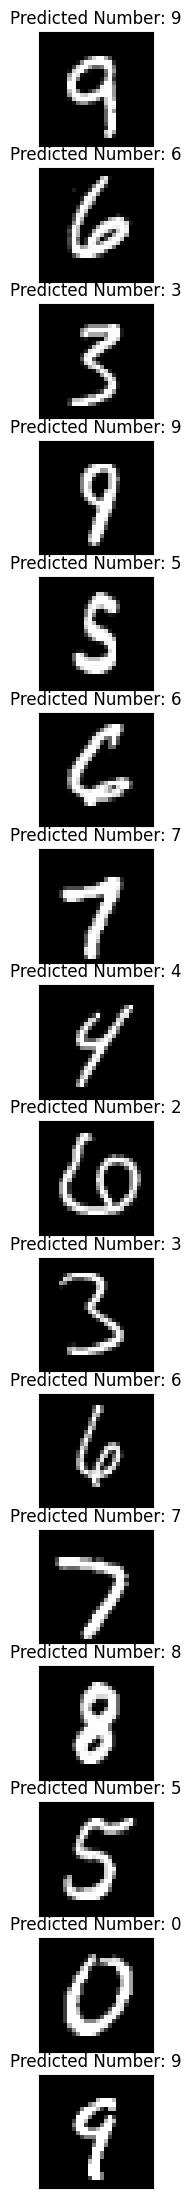

In [12]:
plot_predictions(x_test, y_test)